In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import sys
import os

current_dir = '/scratch/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 


In [ ]:
def parse_wf_from_binary(filename, num_events=500):
    """
    Parse a binary waveform file with one header and multiple sequential events.
    
    Parameters
    ----------
    filename : str
        Path to the binary file.
    num_events : int
        Number of waveform events stored in the file.
    
    Returns
    -------
    pd.DataFrame
    """
    with open(filename, "rb") as f:
        header_bytes = f.read(28)
        if len(header_bytes) < 28:
            raise ValueError("File too short for header")
        
        # Parse header
        EVID = struct.unpack("<I", header_bytes[0:4])[0]
        T = struct.unpack("<Q", header_bytes[4:12])[0]
        sampl_time = struct.unpack("<Q", header_bytes[12:20])[0]
        ch = struct.unpack("<I", header_bytes[24:28])[0]
        
        if ch == 0 or ch > 100:
            raise ValueError(f"Suspicious channel count: {ch}")
        
        waveform_bytes = f.read()
    
    total_samples = len(waveform_bytes) // 4
    samples_per_event = total_samples // (ch * num_events)
    
    if samples_per_event == 0:
        raise ValueError("File does not contain enough data for the given number of events")
    
    data_list = []
    
    for event_idx in range(num_events):
        for si in range(samples_per_event):
            row = {}
            for ci in range(ch):
                offset = (event_idx * samples_per_event * ch + si * ch + ci) * 4
                w_bytes = waveform_bytes[offset:offset+4]
                w = struct.unpack("<f", w_bytes)[0]
                row[f'CH{ci+1}'] = w / 1e3
            row["event"] = EVID + event_idx
            row["event_time"] = T
            data_list.append(row)
    
    df = pd.DataFrame(data_list)
    df.insert(0, 'TIME', (df.index % samples_per_event + 1) * sampl_time / 1e9)
    return df


In [47]:
# run_dir = "/data/marian/cigar/runs/20251015_Xe_Kr_17deg_54.5V_Majority"
# filename = f"{run_dir}/Acq_dig2-192.168.0.254_20251015160926-16.bin"

run_dir = "/data/marian/cigar/runs/20251015_Xe_no_source_17deg_54.5V_Autotrg"
filename = f"{run_dir}/Acq_dig2-192.168.0.254_20251015162641-05.bin"

df = parse_data.parse_wf_from_binary(filename)  
print(df.head())


0 300
           TIME       CH1       CH2       CH3       CH4       CH5  event  \
0  8.000000e-09  0.001413 -0.604890 -0.451556 -0.439281  0.048967   2400   
1  1.600000e-08  0.001598 -0.602496 -0.455542 -0.457682  0.027367   2400   
2  2.400000e-08  0.001475 -0.598998 -0.460572 -0.477616  0.005093   2400   
3  3.200000e-08  0.001413 -0.598261 -0.464804 -0.493563 -0.016875   2400   
4  4.000000e-08  0.001475 -0.603294 -0.470447 -0.504603 -0.039333   2400   

     event_time  
0  150038125198  
1  150038125198  
2  150038125198  
3  150038125198  
4  150038125198  


In [48]:
df.TIME.min()

8e-09

In [49]:
# Filter for a specific event (change index as needed)
event_list = df['event'].unique()
print(len(event_list))

300


In [50]:
selected_event = 100
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


In [53]:
df

,TIME,CH1,CH2,CH3,CH4,CH5,event,event_time
0,8.000000e-09,0.001413,-0.604890,-0.451556,-0.439281,0.048967,2400,150038125198
1,1.600000e-08,0.001598,-0.602496,-0.455542,-0.457682,0.027367,2400,150038125198
2,2.400000e-08,0.001475,-0.598998,-0.460572,-0.477616,0.005093,2400,150038125198
3,3.200000e-08,0.001413,-0.598261,-0.464804,-0.493563,-0.016875,2400,150038125198
4,4.000000e-08,0.001475,-0.603294,-0.470447,-0.504603,-0.039333,2400,150038125198
...,...,...,...,...,...,...,...,...
1499995,3.996800e-05,0.001352,-0.405224,-0.665189,-0.621446,-0.386458,2699,168725549176
1499996,3.997600e-05,0.001475,-0.359190,-0.644089,-0.607155,-0.330741,2699,168725549176
1499997,3.998400e-05,0.001352,-0.319109,-0.623051,-0.587773,-0.281099,2699,168725549176
1499998,3.999200e-05,0.001598,-0.291857,-0.604282,-0.570232,-0.239250,2699,168725549176


In [54]:
# channels = ['CH1', 'CH2', 'CH3', 'CH4']
channels = ['CH2', 'CH3', 'CH4', 'CH5']

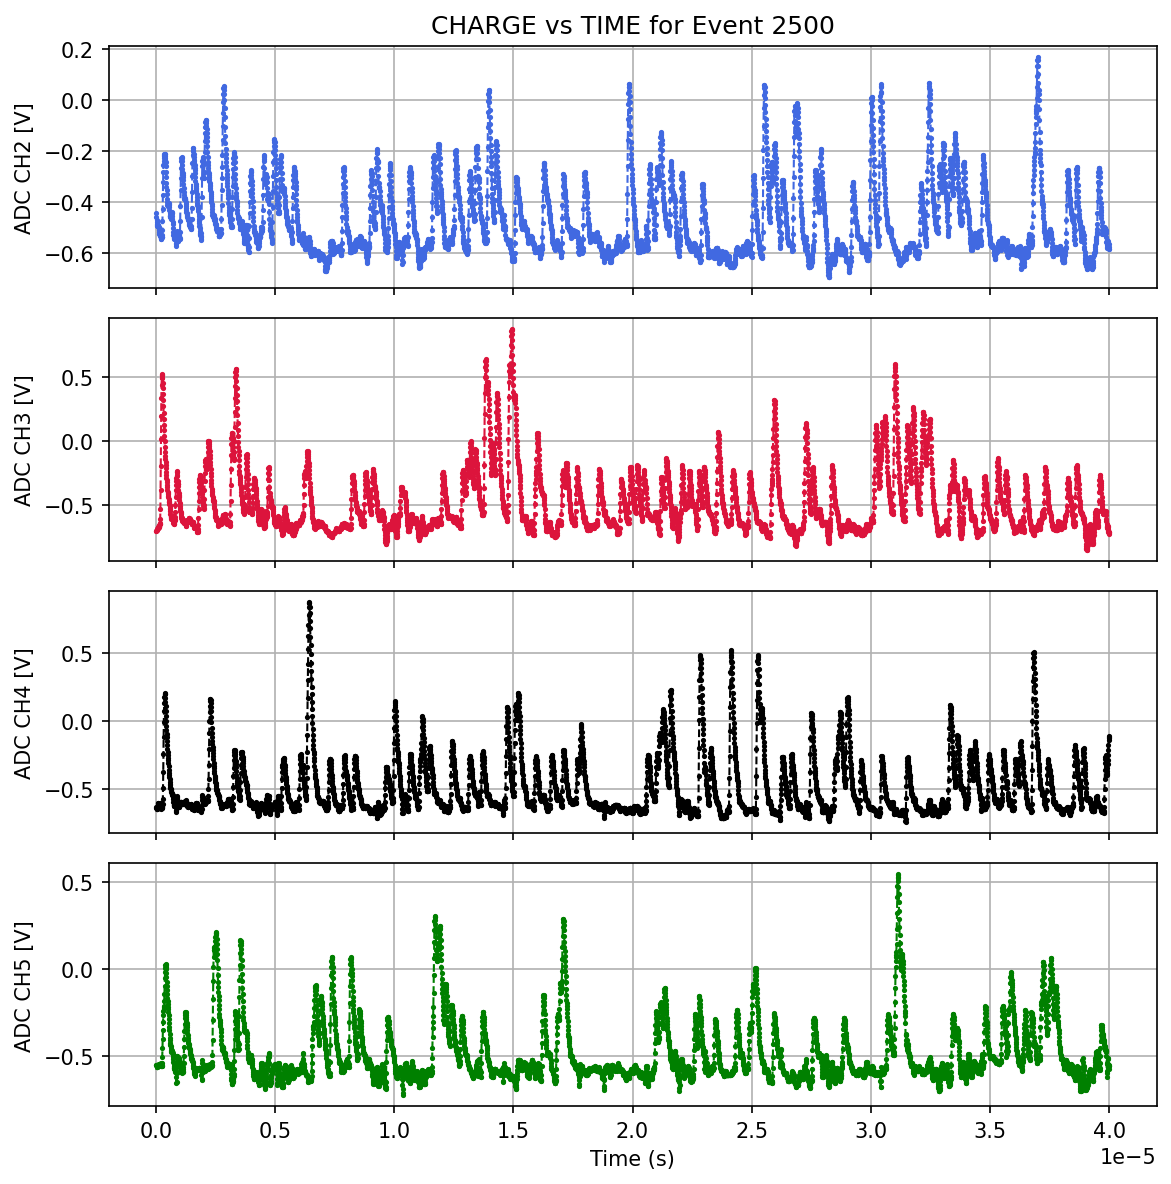

In [55]:
# Create subplots: 2 rows, 1 column
fig, axs = plt.subplots(4, 1, figsize=(8, 8), dpi=150, sharex=True)
colors = ['royalblue', 'crimson', 'black', 'green']

axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]}')

# Plot CHs
for i in range(4):
    # axs[i].plot(df_event['TIME'], (df_event[f'{channels[i]}']-df_event[df_event['TIME']<2e-9][f'{channels[i]}'].mean()), marker='.', linestyle='--',
    axs[i].plot(df_event['TIME'], (df_event[f'{channels[i]}']), marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{channels[i]}')
    axs[i].set_ylabel(f'ADC {channels[i]} [V]')
    axs[i].grid(True)

axs[-1].set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()